In [60]:
import datajoint as dj
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
sns.set_context("talk")

dj.blob.use_32bit_dims = True  # necessary for pd.blob read



import behav_viz.ingest as ingest
import behav_viz.visualize as viz
import behav_viz.utils as utils
from behav_viz.utils import plot_utils as pu
FIGURES_PATH = utils.dir_utils.get_figures_path("rats", "alpha")

import config_alpha_experiment as alpha_config
# settings
%load_ext autoreload
%autoreload 2


[2024-08-29 21:48:57,037][WARNING]: MySQL server has gone away. Reconnecting to the server.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Animals

In [61]:
date_min = alpha_config.ALPHA_START_DATES["alpha_1"]
tdf = ingest.create_trials_df.create_trials_df_from_dj(
    alpha_config.ALPHA_ANIMALS, date_min
)
tdf = ingest.drop_dates(tdf, alpha_config.ALPHA_DATE_DROPS)

animal_id R040
Fetched 40 dates from Sessions table from 2024-07-20 to 2024-08-29 for R040

animal_id R041
Fetched 41 dates from Sessions table from 2024-07-20 to 2024-08-29 for R041

animal_id R042
Fetched 41 dates from Sessions table from 2024-07-20 to 2024-08-29 for R042

animal_id R043
Fetched 42 dates from Sessions table from 2024-07-20 to 2024-08-29 for R043

animal_id R044
Fetched 33 dates from Sessions table from 2024-07-20 to 2024-08-29 for R044

animal_id R045
Fetched 40 dates from Sessions table from 2024-07-20 to 2024-08-29 for R045

animal_id R046
Fetched 41 dates from Sessions table from 2024-07-20 to 2024-08-29 for R046

animal_id R047
Fetched 36 dates from Sessions table from 2024-07-20 to 2024-08-29 for R047

animal_id R048
Fetched 32 dates from Sessions table from 2024-07-27 to 2024-08-29 for R048

animal_id R049
Fetched 31 dates from Sessions table from 2024-07-29 to 2024-08-29 for R049

animal_id R050
Fetched 34 dates from Sessions table from 2024-07-27 to 2024-08-2

## Plot Over Days Summaries

### Probe Stages


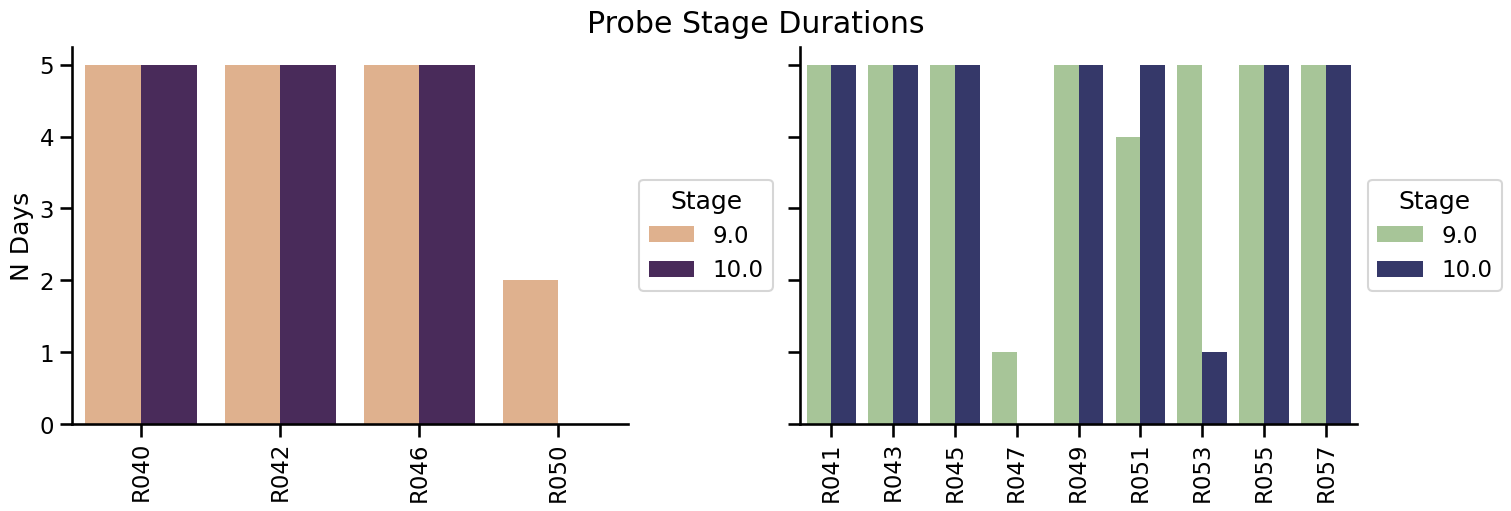

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True, sharey=True)
plt.suptitle("Probe Stage Durations")
for i, (exp, sub_df) in enumerate(tdf.groupby("fix_experiment")):
    viz.FixationGrower.exp_compare_alpha.plot_stage_in_stage_by_animal_single_experiment(
        sub_df, experiment=exp, min_stage=9, max_stage=10, ax=ax[i]
    )

/Users/jessbreda/Desktop/github/jbreda_animal_training/src/behav_viz/visualize/FixationGrower/df_preperation.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ).apply(compute_failed_fixation_rate)
/Users/jessbreda/Desktop/github/jbreda_animal_training/src/behav_viz/visualize/FixationGrower/df_preperation.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ).apply(compute_failed_fixation_rate)


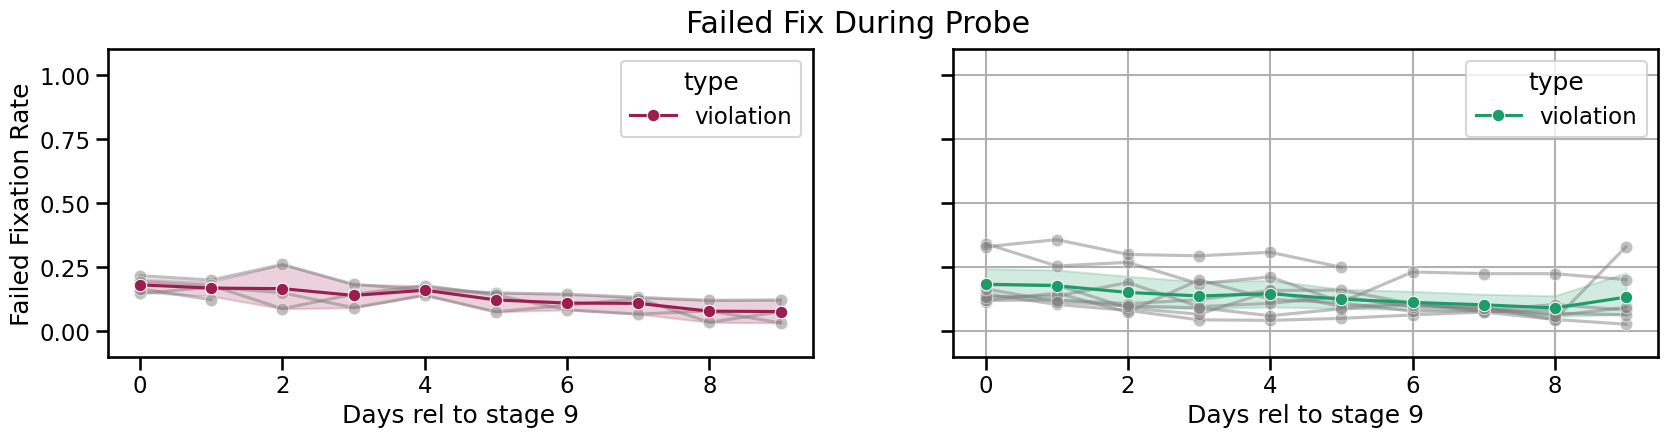

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4), sharex=True, sharey=True)
plt.suptitle("Failed Fix During Probe")

for i, (exp, sub_df) in enumerate(tdf.groupby("fix_experiment")):
    viz.FixationGrower.exp_compare_alpha.plot_failed_fixation_rate_single_experiment(
        sub_df,
        experiment=exp,
        ax=ax[i],
        title=exp,
        min_stage=9,
        max_stage=10,
        relative_to_stage=9,
    )
    ax[i].grid()

/Users/jessbreda/Desktop/github/jbreda_animal_training/src/behav_viz/visualize/FixationGrower/df_preperation.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ).apply(compute_failed_fixation_rate)
/Users/jessbreda/Desktop/github/jbreda_animal_training/src/behav_viz/visualize/FixationGrower/df_preperation.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ).apply(compute_failed_fixation_rate)


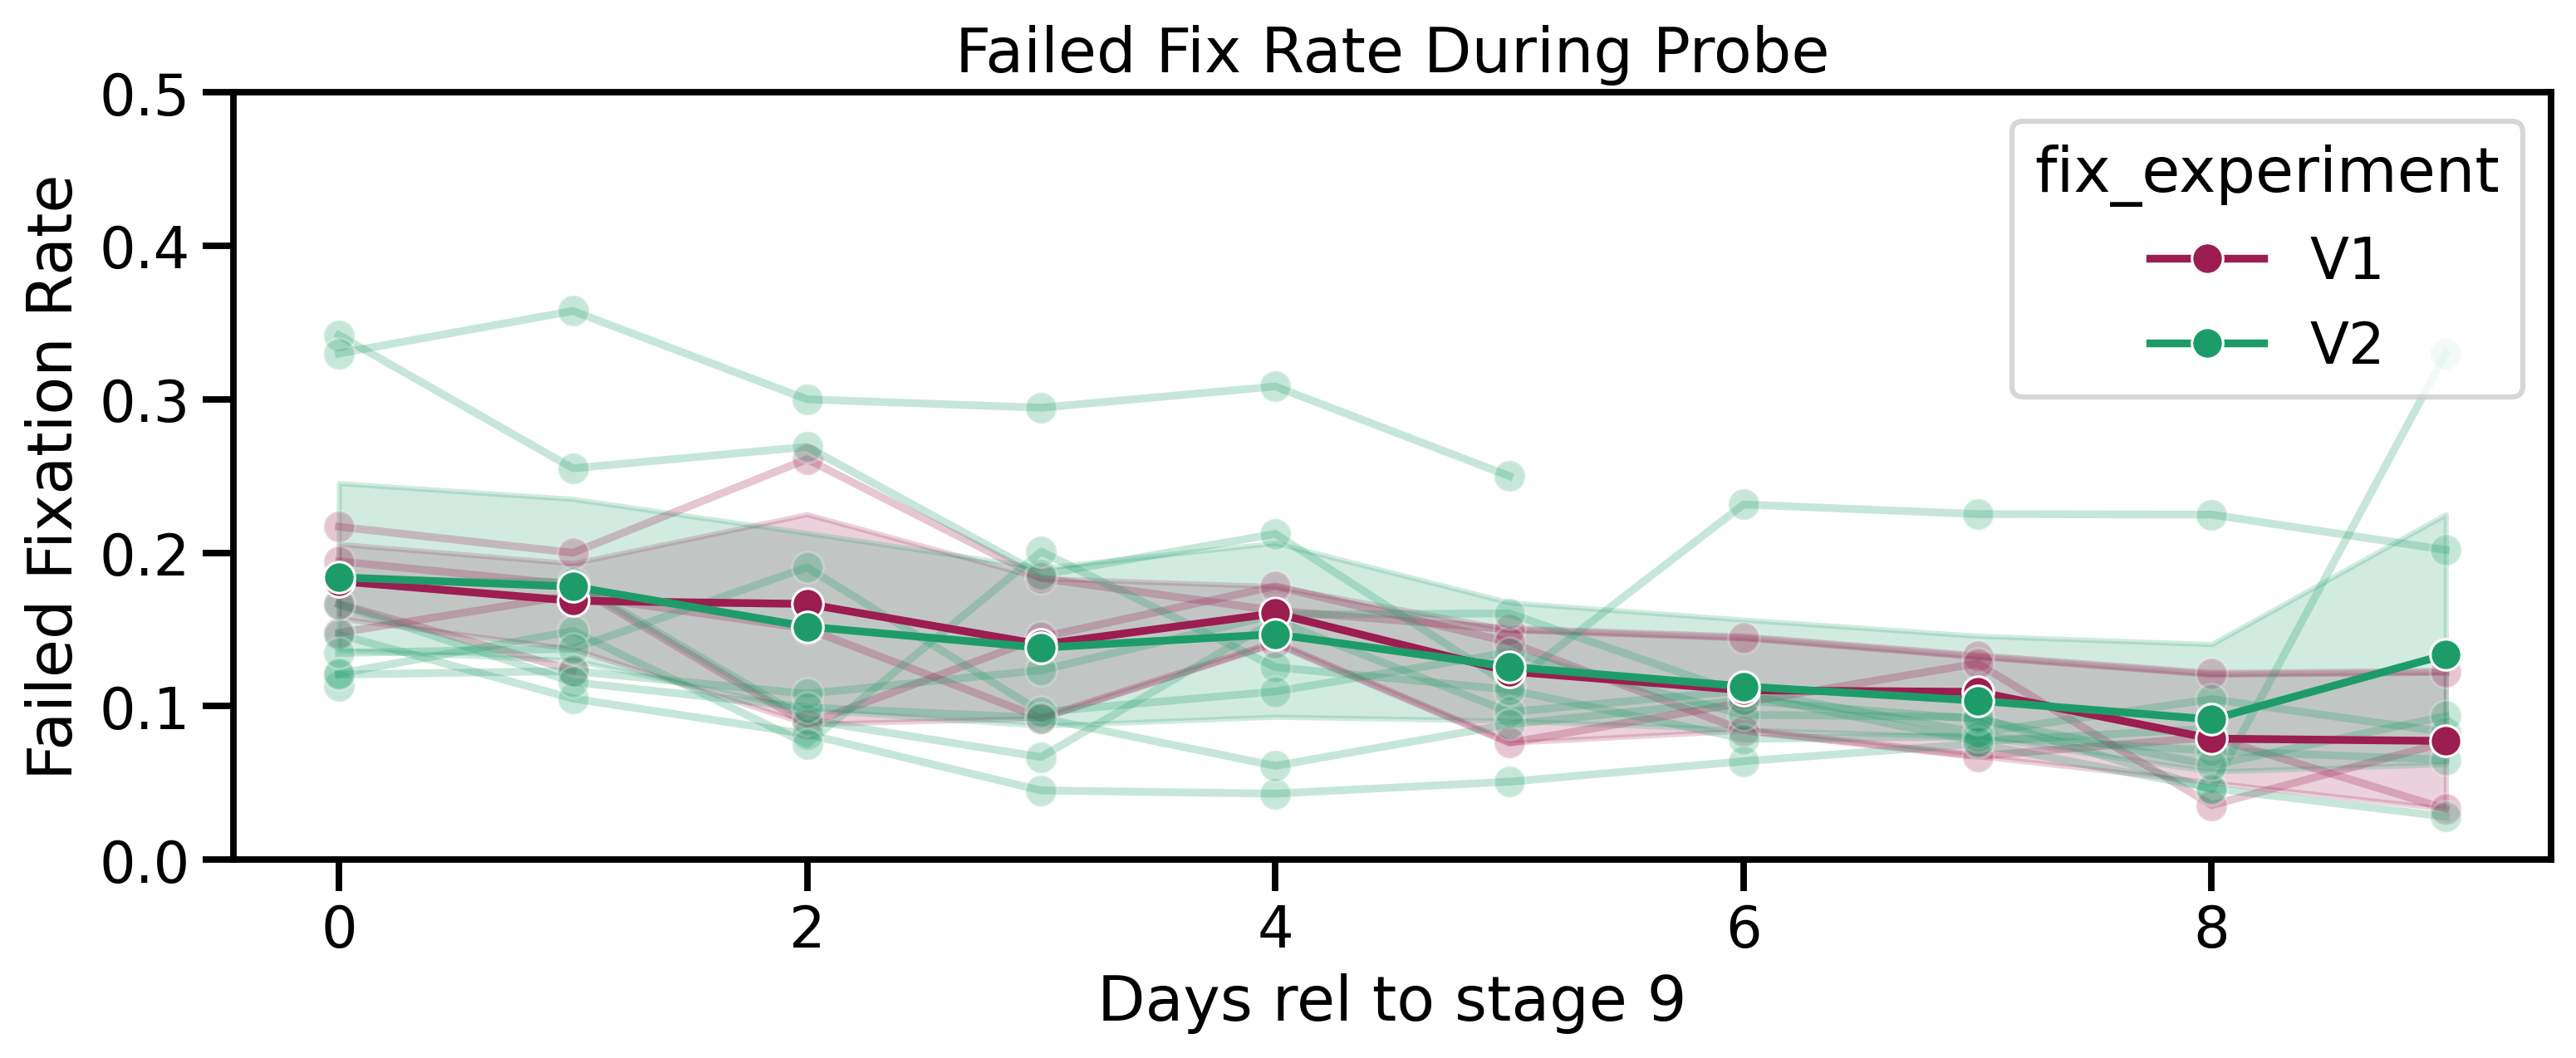

In [64]:
viz.FixationGrower.exp_compare_alpha.plot_failed_fixation_rate_compare_experiment(
    tdf,
    min_stage=9,
    max_stage=10,
    relative_to_stage=9,
    title="Failed Fix Rate During Probe",
)

/Users/jessbreda/Desktop/github/jbreda_animal_training/src/behav_viz/visualize/FixationGrower/df_preperation.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ).apply(compute_failed_fixation_rate)
/Users/jessbreda/Desktop/github/jbreda_animal_training/src/behav_viz/visualize/FixationGrower/df_preperation.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ).apply(compute_failed_fixation_rate)
/Users/jessbreda/Desktop/github/jbreda_animal_training/src/behav_viz/visualize/FixationGrower/df_p

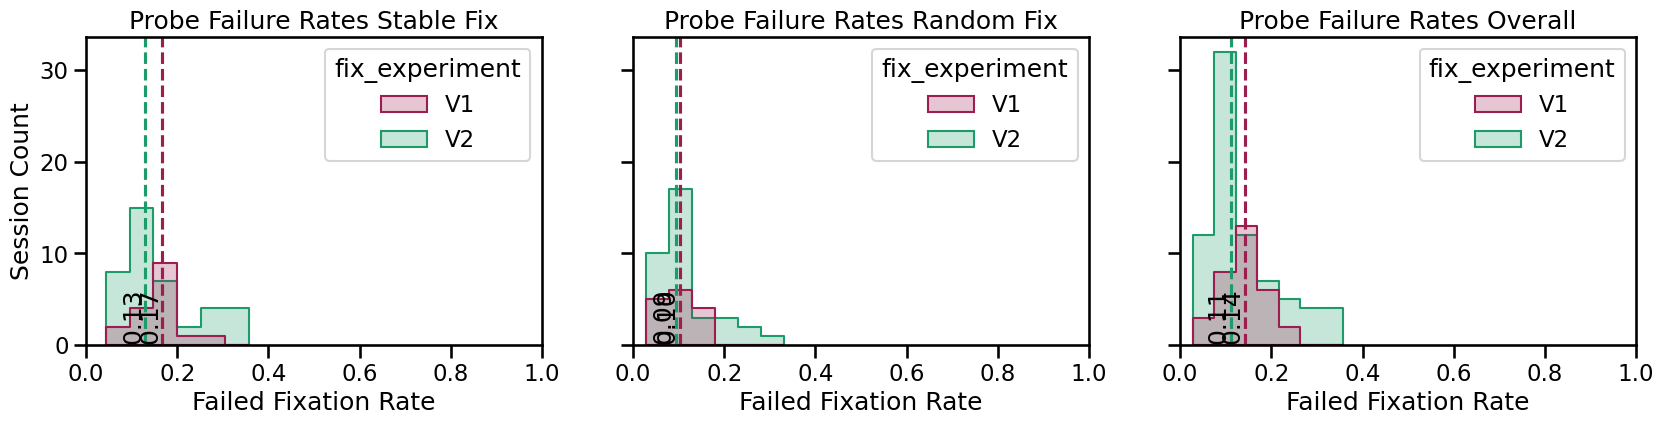

In [65]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharex=True, sharey=True)
viz.FixationGrower.exp_compare_alpha.plot_failed_fixation_histogram_compare_experiment(
    tdf,
    ax=ax[0],
    min_stage=9,
    max_stage=9,
    title="Probe Failure Rates Stable Fix",
)

viz.FixationGrower.exp_compare_alpha.plot_failed_fixation_histogram_compare_experiment(
    tdf,
    ax=ax[1],
    min_stage=10,
    max_stage=10,
    title="Probe Failure Rates Random Fix",
)

viz.FixationGrower.exp_compare_alpha.plot_failed_fixation_histogram_compare_experiment(
    tdf,
    ax=ax[2],
    min_stage=9,
    max_stage=10,
    title="Probe Failure Rates Overall",
)

/Users/jessbreda/Desktop/github/jbreda_animal_training/src/behav_viz/visualize/FixationGrower/df_preperation.py:252: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["animal_id", "fix_experiment"])[


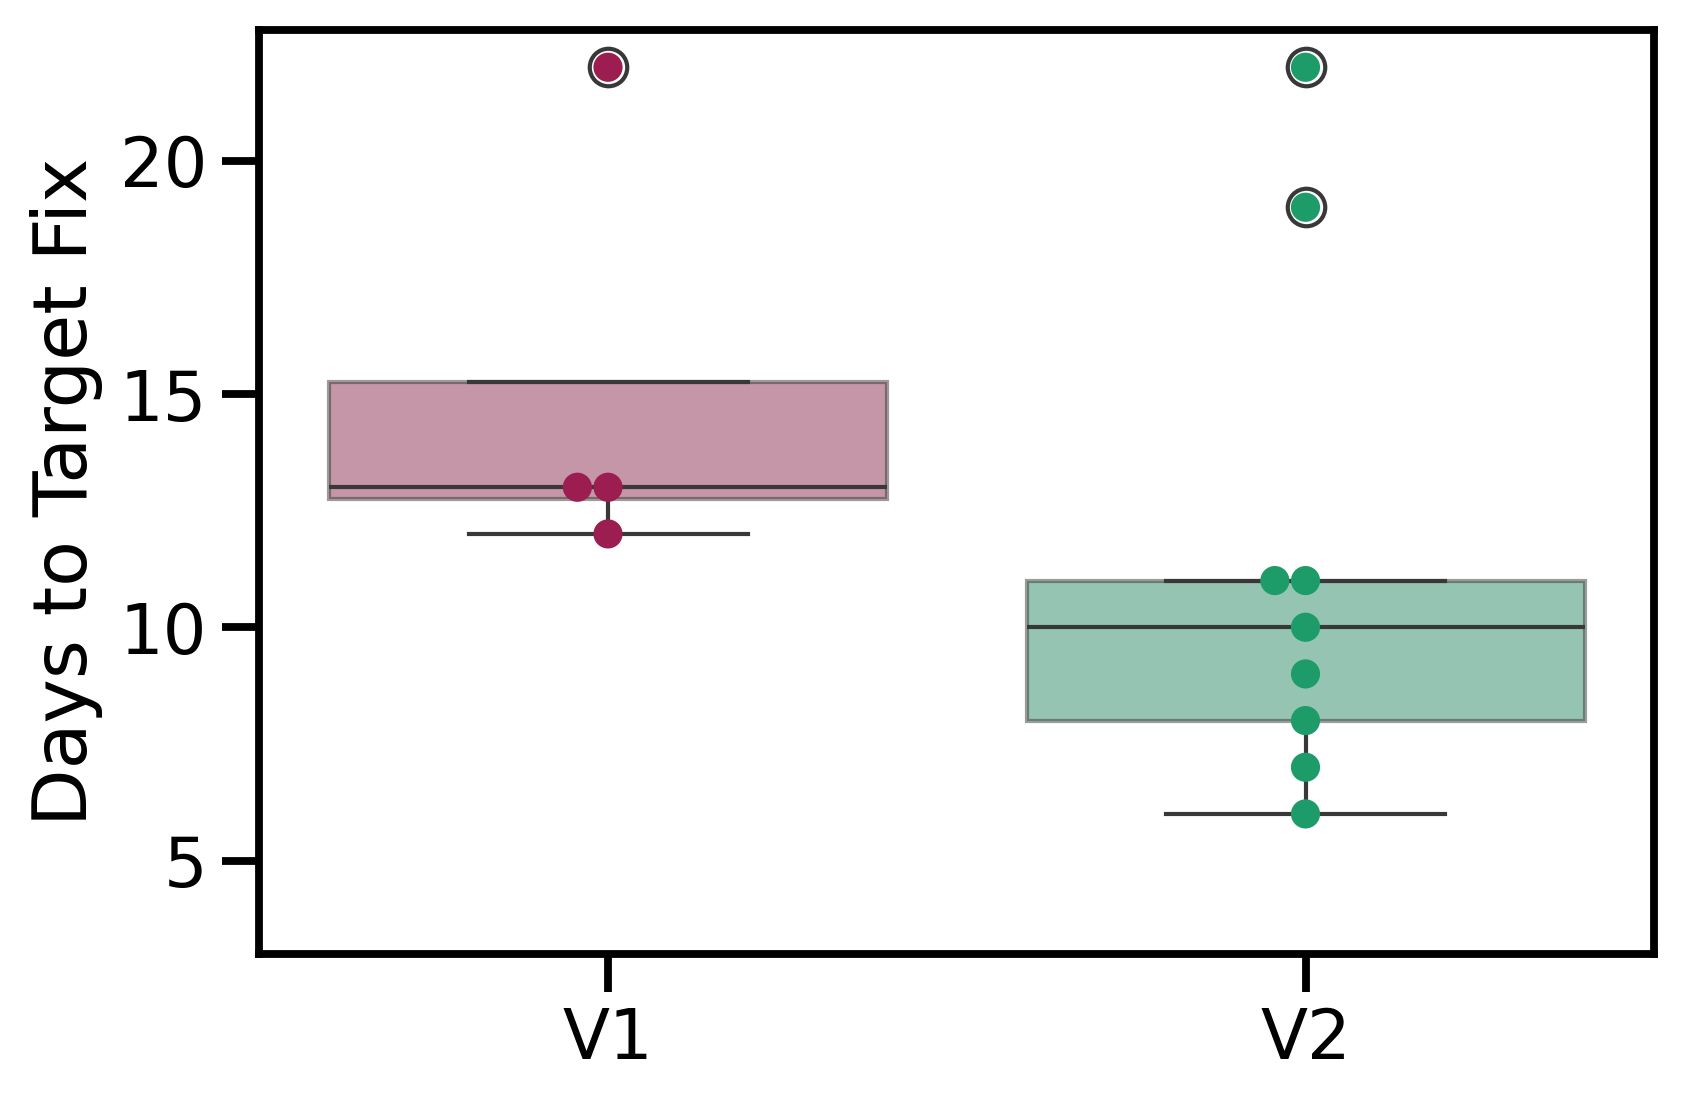

In [69]:
viz.FixationGrower.exp_compare_alpha.plot_days_to_reach_target_fix_boxplot_compare_experiment(
    tdf
)

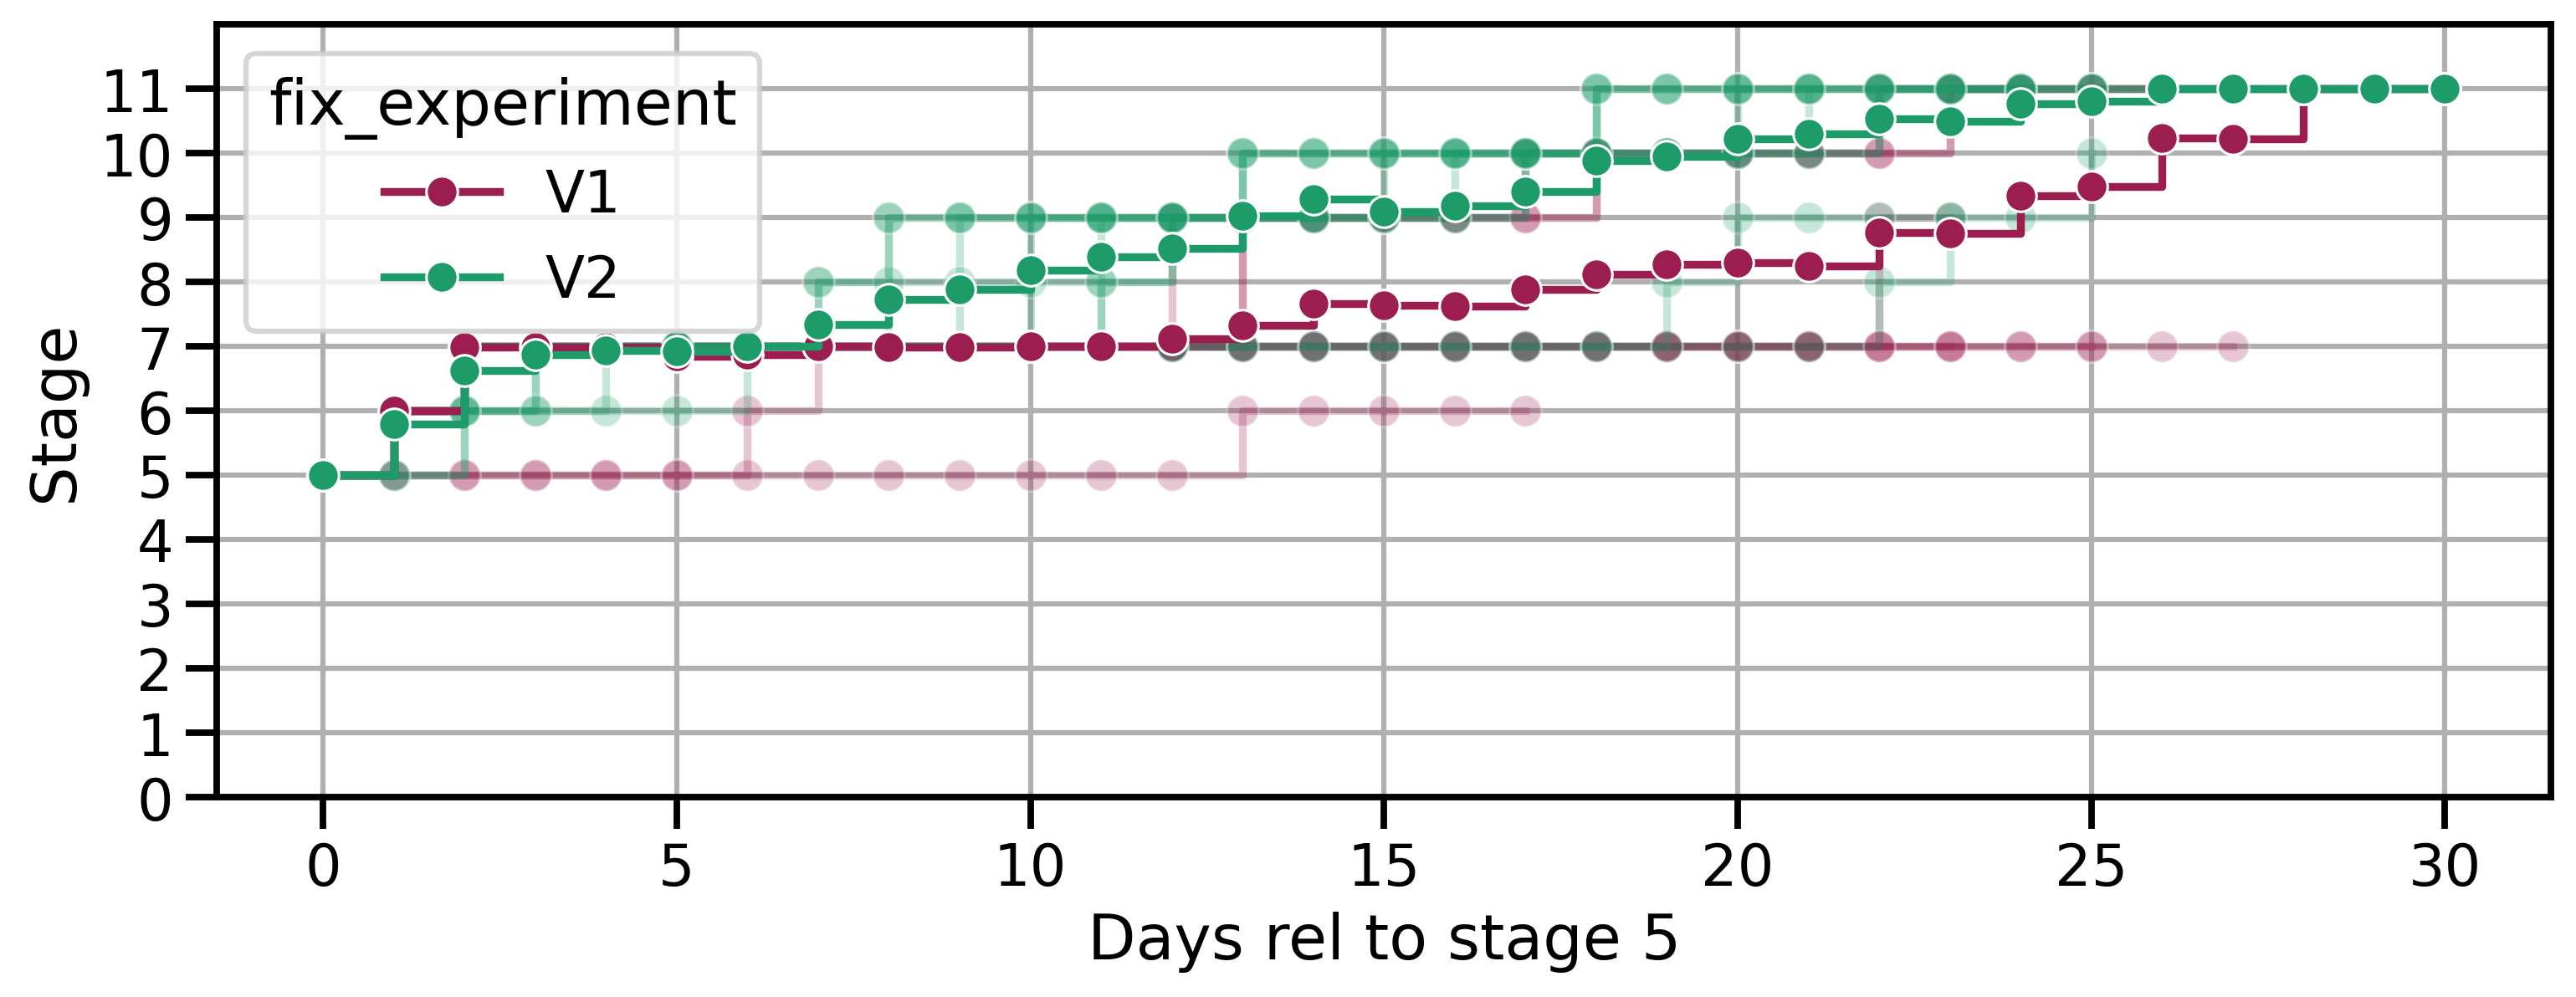

In [67]:
plot_df = tdf.query("stage >= 5").copy()
fig, ax = pu.make_fig()
viz.FixationGrower.exp_compare_alpha.plot_stage_compare_experiments(
    plot_df, relative_to_stage=5, ax=ax
)



### Cpoke Learning


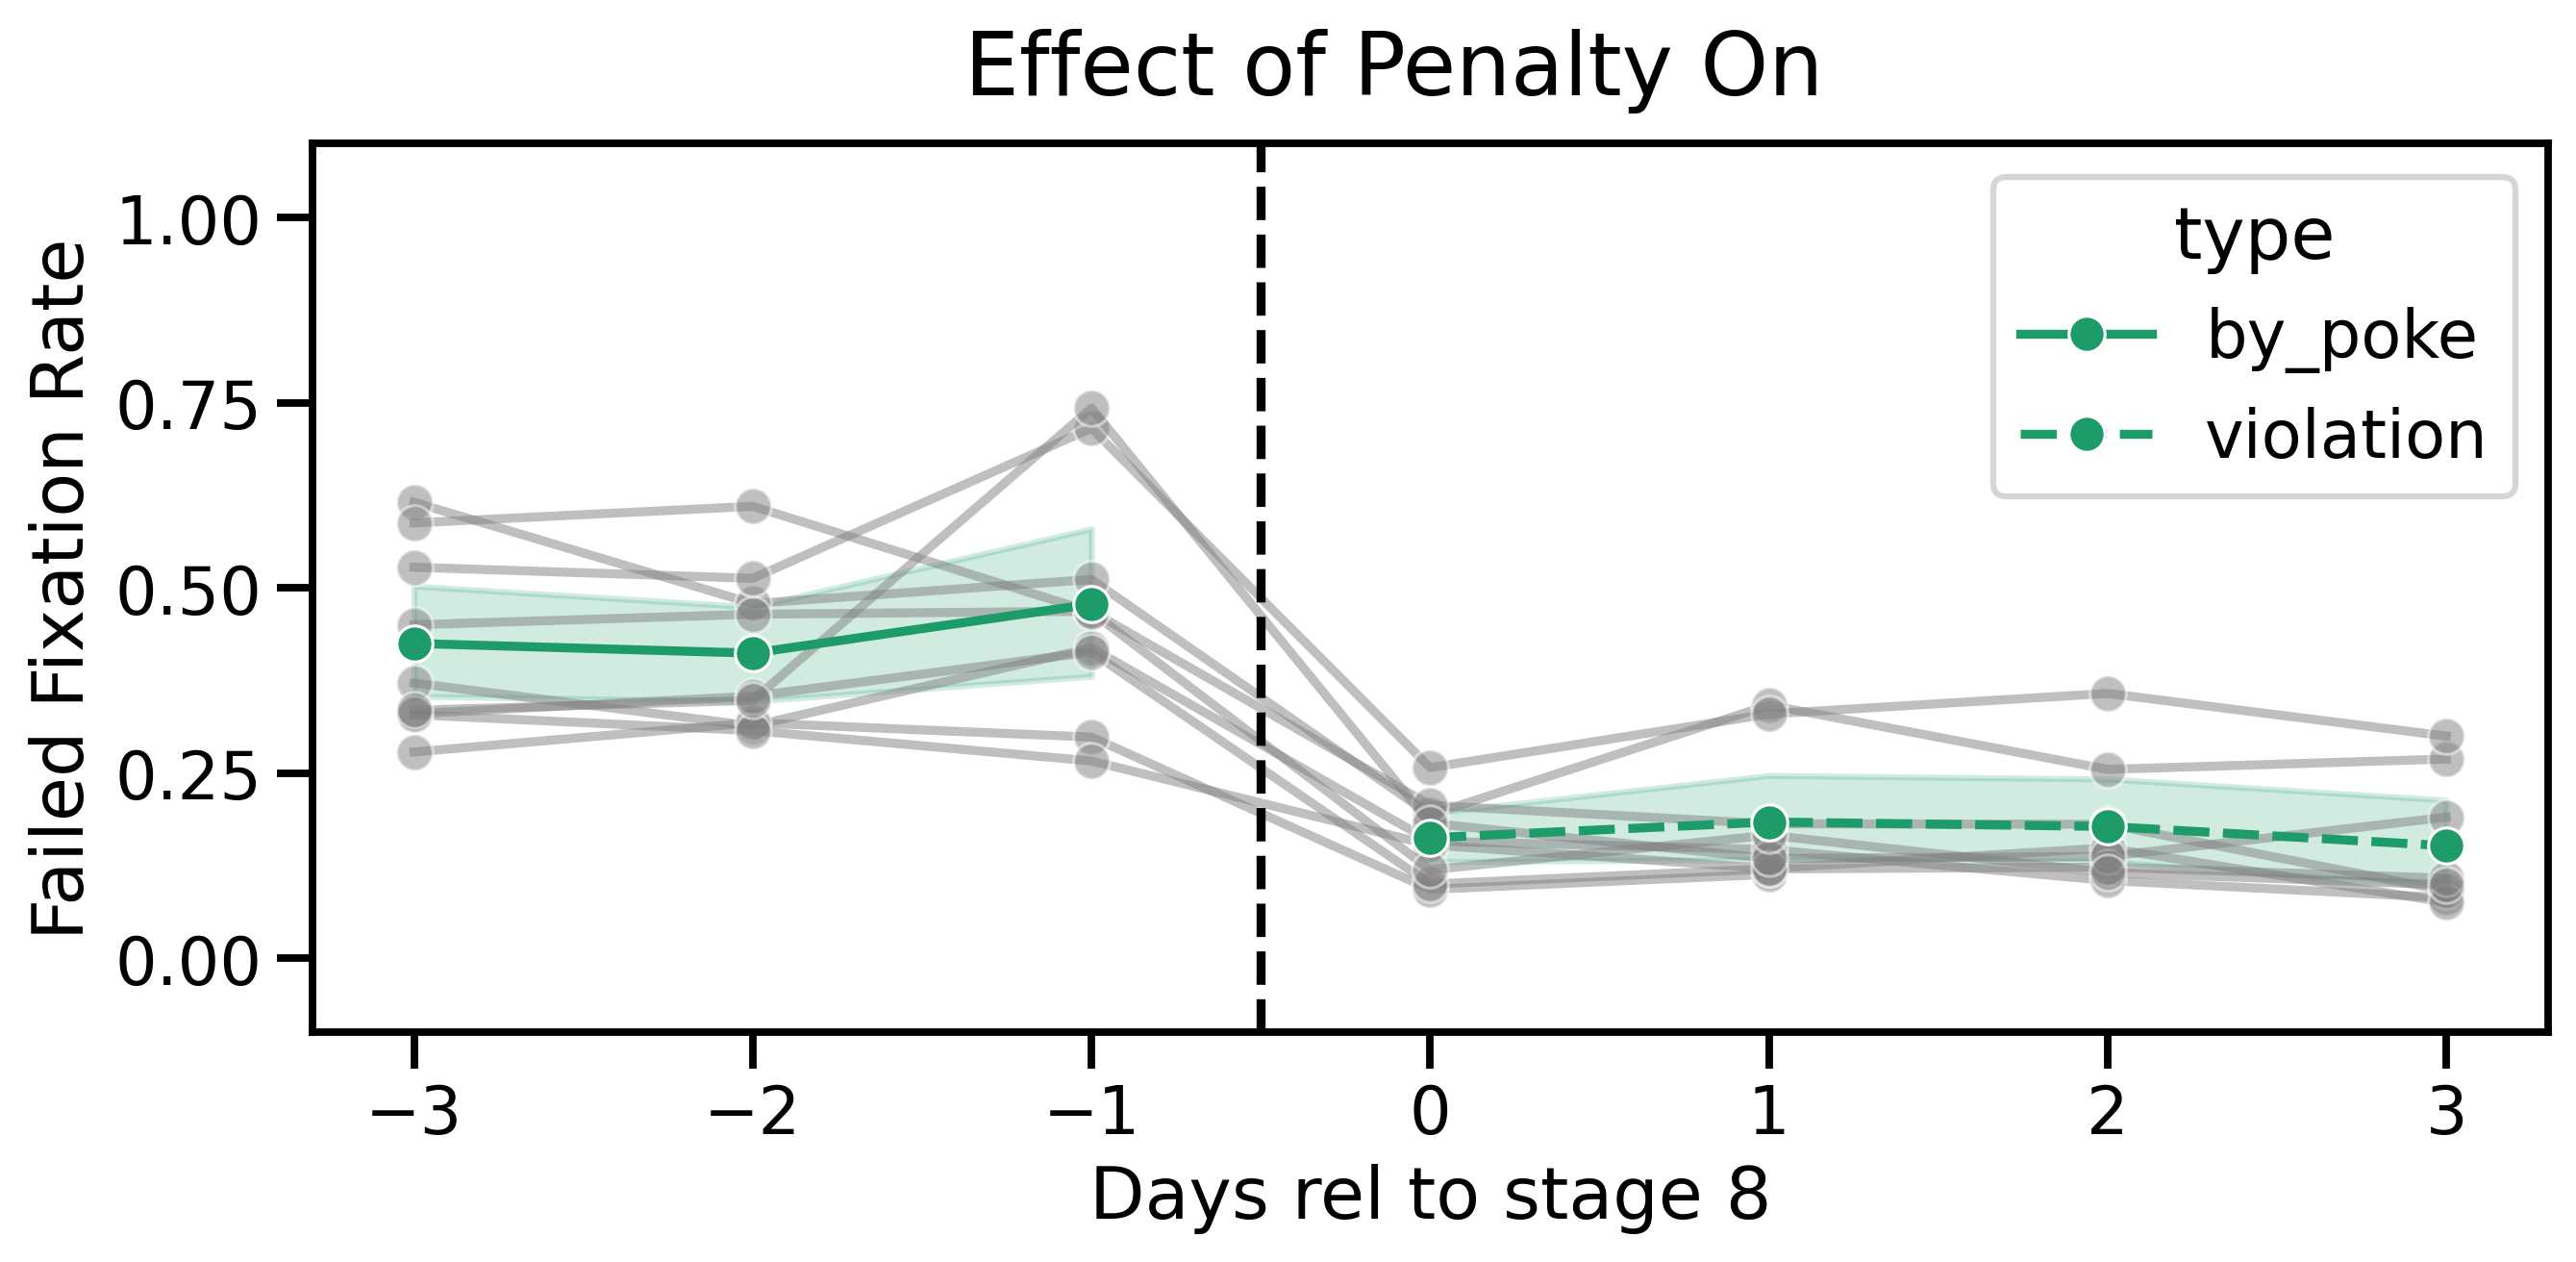

In [68]:
fig, ax = pu.make_fig((10, 4))
plt.suptitle("Effect of Penalty On")

viz.FixationGrower.exp_compare_alpha.plot_failed_fixation_rate_turn_penalty_on(
    tdf, ax=ax, max_stage=9, day_range=(-3, 3), style="type"
)

ax.grid()


### Cpoke Learning